In [1]:
import torch
import torchvision
import torch.optim as optim
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset

import transformers
from datasets import load_dataset
from transformers import DetrImageProcessor, DetrForObjectDetection, AutoModelForObjectDetection

import os
import random
from tqdm import tqdm
from argparse import Namespace

import numpy as np
import albumentations
from albumentations import pytorch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

## Getting Set Up

To embark on this thrilling adventure, you'll need a few things in place:

- **Library Magic**: Make sure you've conjured up the right libraries, such as PIL, torch, and transformers.

- **Model of the Hour**: Define your choice of DETR model. In this tutorial, we're rolling with the `facebook/detr-resnet-50`.

- **Cache Treasures**: Set the cache directory to ensure your data is stored safely.

- **Choosing Your Path**: Decide whether you want to go with CPU or GPU (`device` variable). CPU provides a smooth ride, but if you're equipped with a powerful GPU, don't hesitate to hop on board.

## Unearthing the Dataset

Our first pit stop is the dataset that contains a variety of road sign images along with their object annotations. We'll use this dataset to showcase DETR's talents.

Every adventurer needs to understand the locals. In our case, it's the road signs. We decode the category information from the dataset and create two maps:
- **id2label**: This dictionary helps us translate category IDs to labels.
- **label2id**: It's the guide that helps us identify category labels and map them to IDs.


### Data Fields
- image_id: the image id
- image: PIL.Image.Image object containing the image. Note that when accessing the image column: dataset[0]["image"] the image file is automatically decoded. Decoding of a large number of image files might take a significant amount of time. Thus it is important to first query the sample index before the "image" column, i.e. dataset[0]["image"] should always be preferred over dataset["image"][0]
- width: the image width
- height: the image height
- objects: a dictionary containing bounding box metadata for the objects present on the image
    - id: the annotation id
    - area: the area of the bounding box
    - bbox: the object's bounding box (in the coco format)
    - category: the object's category.

In [2]:
# Define the model and cache directory
model_id = "facebook/detr-resnet-50"
cache_dir = ".cache/.huggingface"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set batch size
bs = 16

In [3]:
# Load the dataset
dataset = load_dataset("Francesco/road-signs-6ih4y", cache_dir=cache_dir)

# Access category information
categories = dataset["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories)}
label2id = {v: k for k, v in id2label.items()}

dataset['train'][0]

Found cached dataset parquet (/archive/turganbay/.huggingface/Francesco___parquet/Francesco--road-signs-6ih4y-65f131ea1a7375ba/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

{'image_id': 870,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [944],
  'area': [19135],
  'bbox': [[255.0, 227.0, 107.5, 178.0]],
  'category': [7]}}

Now that we're all geared up, it's time to set sail. We'll choose an image from the dataset and plot it to see how the dataset looks like.

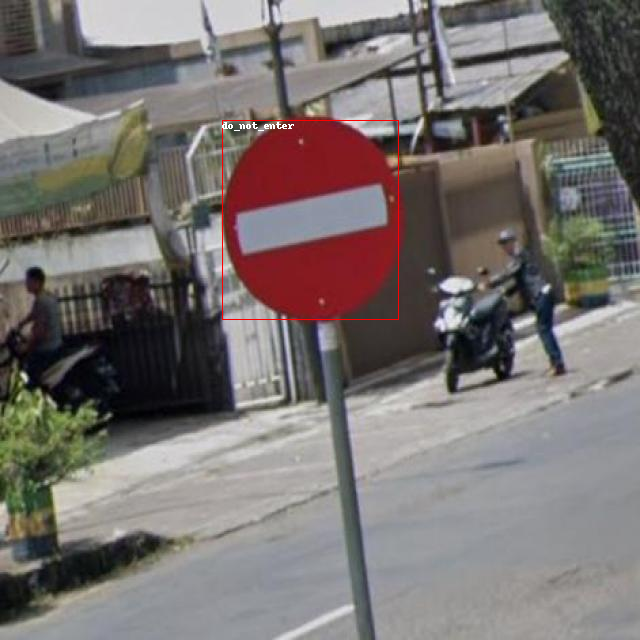

In [23]:
# Display an image with bounding box annotations
idx = random.randint(1, len(dataset['train'])-1)
image = dataset["train"][idx]["image"]
annotations = dataset["train"][idx]["objects"]
draw = ImageDraw.Draw(image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

# Data Augmentation and Dataset Preparation

Before we dive into the world of object detection with DETR, we need to prepare our data. This preparation involves two main steps: data augmentation and dataset creation.

## Data Augmentation

Data augmentation is a technique commonly used in computer vision, including object detection, to enhance the diversity of the training dataset. This is important because it helps our model become more robust and effective at recognizing objects in various scenarios. We achieve this by applying various transformations to our images. Here's what we're doing:

- **Resize**: We're making sure all images have the same dimensions, 480x480 pixels, for consistency.

- **Vertical and Horizontal Flips**: These flips simulate different object orientations, making our model more adaptable.

- **Random Brightness and Contrast Adjustments**: These adjustments mimic real-world lighting conditions, helping our model cope with different illumination scenarios.

## Building the Dataset

To efficiently manage our dataset, we've created a custom dataset class. We've formatted the bounding box annotations in a way that DETR can understand. This format includes information about the image, the object's category, area, and bounding box coordinates. We've divided the data into training and testing subsets and applied the appropriate transformations for each subset, including data augmentation for training and resizing for testing.

## Organizing the Data

Organizing the data is a crucial step in preparing it for training and testing. We're using the `AutoImageProcessor` from the Transformers library to process our images. This processor converts the images into a format that DETR can work with.

With these steps completed, our dataset is ready to guide us through the object detection adventure. It contains the images, properly formatted annotations, and everything needed for training and testing.

In [24]:
transform = albumentations.Compose([
    # albumentations.LongestMaxSize(max_size=800),
    # albumentations.ColorJitter(p=0.7),
    # albumentations.BBoxSafeRandomCrop(p=0.2),
    albumentations.RandomBrightnessContrast(p=0.1),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['category']))

In [4]:
def preprocess_dataset_train(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        area.append(objects["area"])
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
    return {"images": images, "image_ids": image_ids, "bboxes": bboxes, "area": area, "categories": categories}


def preprocess_dataset_test(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        area.append(objects["area"])
        images.append(image)
        bboxes.append(objects["bbox"])
        categories.append(objects["category"])   
    return {"images": images, "image_ids": image_ids, "bboxes": bboxes, "area": area, "categories": categories}

In [5]:
def collate_fn(batch):
    """
    Collates a batch of data, processing images and annotations for use in an object detection model.

    Args:
        batch (list): A list of data items, where each item is a dictionary containing image and annotation information.

    Returns:
        dict: A dictionary containing the processed data for use in object detection. The dictionary includes the following keys:
        - 'pixel_values': Processed image data.
        - 'pixel_mask': Image mask.
        - 'target_sizes': Sizes of target images.
    """
    images = [item['images'] for item in batch]
    image_ids = [item['image_ids'] for item in batch]
    bboxes = [item['bboxes'] for item in batch]
    area = [item['area'] for item in batch]
    categories = [item['categories'] for item in batch]
    
    # save for image post-processing after the inference 
    trg_sizes = [torch.tensor(item['images'].shape[:2][::-1]) for item in batch]
    
    targets = []
    for image_id, category, area, bbox in zip(image_ids, categories, area, bboxes):
        annotations = []
        for i in range(0, len(category)):
            new_ann = {
                "image_id": image_id,
                "category_id": category[i],
                "isCrowd": 0,
                "area": area[i],
                "bbox": list(bbox[i]),
            }
            annotations.append(new_ann)

        item = {"image_id": image_id, "annotations": annotations}
        targets.append(item)

    batch = image_processor(images=images, annotations=targets, return_tensors="pt")
    encoding = image_processor.pad(batch['pixel_values'], return_tensors="pt")
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["target_sizes"] = torch.stack(trg_sizes)
    return batch

In [7]:
def _box_xywh_to_xyxy(box):
    xmin = box[0]
    xmax = xmin + box[2]
    ymin = box[1]
    ymax = ymin + box[3]
    return [xmin, ymin, xmax, ymax]

def _box_cxcywh_to_xyxy(boxes: torch.Tensor) -> torch.Tensor:
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h

    boxes = torch.stack((x1, y1, x2, y2), dim=-1)
    return boxes

**The DetrImageProcessor** is used for preparing images and their annotations for object detection tasks with the DETR model. It is essential to note that the input annotations should be in the COCO bounding box format, which is (x, y, width, height).

Inside the processing pipeline, the DetrImageProcessor transforms the annotations to the format required by the DETR model, which is (center_x, center_y, width, height). This format is crucial for DETR's proper functioning.

Some key functionalities of the DetrImageProcessor include resizing, rescaling, normalizing, and padding images. Additionally, it can perform post-processing on model predictions, such as thresholding and scaling bounding boxes back to the image size, all of which can be tweaked when initializing the processor. This makes it an invaluable component when working with object detection tasks using the DETR architecture.

If you want to turn off some of the default functionalities, take into consideration that:
- do_resize resizes and changes box format to xyxy at the end
- do_normalize expects input in xyxy format and does corners_to_center, which is just transformation to cxcywh format

In [6]:
image_processor = DetrImageProcessor.from_pretrained(model_id, cache_dir=cache_dir)
image_processor.size["longest_edge"] = 1000
image_processor.size["shortest_edge"] = 600

train = dataset["train"].with_transform(preprocess_dataset_train)
validation = dataset["validation"].with_transform(preprocess_dataset_test)
test = dataset["test"].with_transform(preprocess_dataset_test)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


# Trainer

Training a model requires a well-structured and efficient training process. Let's explore the key components of our `Trainer` class, which orchestrates the training of our DETR model. The Trainer class is the orchestrator of our model's training process. It initializes with various parameters, including the model itself, data loaders, and hyperparameters. t ensures the model is placed on the correct device (CPU or GPU) for training. The optimizer and learning rate scheduler are set up for the training process.

`train_one_epoch` method handles one complete training epoch. It iterates through the training data, computes the loss, and performs gradient accumulation if specified. It calculates and returns the average training loss for the epoch.

The `evaluate` method assesses the model's performance on the validation set. It calculates and returns the average validation loss.

In [7]:
class TrainerDETR:
    def __init__(self, model, hparams, *args, **kwargs):
        #if torch.cuda.device_count() > 1:
        #    model = torch.nn.DataParallel(model)
        self.model = model.to(hparams.device)
        self.train_loader = hparams.train_loader
        self.val_loader = hparams.val_loader
        self.num_epochs = hparams.num_epochs
        self.grad_accum_steps = hparams.grad_accum_steps
        self.device = torch.device(hparams.device)
        self.best_val_loss = float("inf")
        self.optimizer = optim.AdamW(model.parameters(), lr=hparams.learning_rate)
        if hparams.scheduler:
            self.scheduler = transformers.get_scheduler(hparams.scheduler, self.optimizer, hparams.num_warmup_steps, hparams.num_training_steps)
        if hparams.save_path is None:
            self.save_path = "best_model.pth"
        else:
            self.save_path = hparams.save_path

    def train_one_epoch(self, loader):
        self.model.train()
        train_losses = []
        progress_bar = tqdm(loader, unit="batch")

        # Training Phase
        for batch_idx, batch in enumerate(progress_bar):
            batch_ = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "target_sizes"]}
            labels = [{k: v.to(device) for k, v in element.items()} for element in batch["labels"]]

            out = self.model(**batch_, labels=labels)
            loss = out.loss / grad_accum_steps
            loss.backward()

            # Gradient accumulation (if needed)
            if (batch_idx + 1) % self.grad_accum_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
                if self.scheduler is not None:
                    self.scheduler.step()

            train_losses.append(loss.item()*grad_accum_steps)
            losses_dict = {k: v.detach().cpu().numpy() for k,v in out["loss_dict"].items()}
            progress_bar.set_postfix({"train_loss": f"{loss.item()*grad_accum_steps:.4f}", **losses_dict})

        train_loss = np.mean(train_losses)
        return train_loss


    def evaluate(self, loader):
        self.model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(loader):
                batch_ = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "target_sizes"]}
                labels = [{k: v.to(device) for k, v in element.items()} for element in batch["labels"]]
                out = self.model(**batch_, labels=labels)
                loss = out.loss
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        return val_loss


    def train(self):
        for epoch in range(self.num_epochs):
            train_loss = self.train_one_epoch(self.train_loader)
            val_loss = self.evaluate(self.val_loader)
            
            if val_loss < self.best_val_loss:
                print(f"Saving... \
                      \nImproved on val_loss from {round(self.best_val_loss, 3)} to {round(val_loss, 3)}")
                self.best_val_loss = val_loss

                # Save the model checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, self.save_path)
            else:
                print(f"Did not improve on val loss: {round(self.best_val_loss, 3)}")

                
    def predict(self, batch): 
        self.model.eval()
        with torch.no_grad():
            p_values = batch["pixel_values"].to(device)
            p_mask = batch["pixel_mask"].to(device)
            out = self.model(p_values, p_mask)    
        return out
 

    def load_state_dict(self, pathname):
        if os.path.exists(pathname):
            ckpt = torch.load(pathname)
            self.model.load_state_dict(ckpt["model_state_dict"])
        else:
            raise ValueError(f"Provided path {pathname} does not exist")

In [8]:
# Prepare the dataloaders
train_loader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(validation, batch_size=bs, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test, batch_size=bs, shuffle=False, num_workers=4, collate_fn=collate_fn)

### Instantiate the model

Let's break down the DETR (DEtection TRansformer) model and its architecture step by step:

**DETR Architecture**:

DETR consists of three main components: the CNN Backbone, the Transformer Encoder, and the Transformer Decoder.

**1. Backbone**:
   - The Backbone is typically a CNN architecture like ResNet-50 or ResNet-101. Its role is to generate low-resolution feature maps from the input image.
   - For example, if the input image has dimensions [3, H0, W0], the Backbone reduces it to feature maps with dimensions [C, H, W].
   - If ResNet-50 is used, the width and height are scaled down by a factor of 32. This is done through the convolutional and pooling layers.
   - A 1x1 convolution is applied to reduce the number of channels from C (2048 for ResNet-50) to a smaller value, denoted as "d." The feature map shape becomes [d, H, W].

**2. Transformer Encoder**:
   - The Transformer Encoder is a key part of the DETR architecture. It leverages the features extracted by the Backbone.
   - It follows the general principles of the Transformer architecture, which you can explore further if needed.
   - Similarities with traditional Transformers include taking the image features (akin to token or word embeddings) and applying positional encodings.

**3. Transformer Decoder**:
   - The Transformer Decoder is responsible for making predictions based on the encoded information from the Encoder. It performs tasks object classification and bounding box regression to identify and locate objects in the image.
   - Learnable object queries are used for both object classification and bounding box regression. Default number of object queries is 100, since the max number of possible objects per image in COCO was not more than 100.
   - The model is trained to assign object queries to objects in the image, making it capable of identifying and localizing multiple objects simultaneously. If there are not many objects in the image, it predicts a no_object class.

**Positional Encodings**:
   - One noteworthy difference in DETR's Transformer architecture is how positional encodings are handled.
   - Unlike the traditional Transformer, where positional encodings are added to both queries and keys, in DETR, they are added only to queries and keys, not to the values.
   - This choice is based on established practices in the vision domain.
   - DETR uses both fixed and learnable positional encodings to incorporate spatial information into the model's understanding of the image.



## NOTE
We decrease eos_coef, since we do not have many objects per image. If you have enough train data, another option might be decreasing the number of queries. eos_coef is a relative classification weight applied to the no-object category. Also try increasing class_cost, which te weight used for class_loss. Since default value for box_loss is 5, I choose a bit higher weight for class_loss. 

In [9]:
model = DetrForObjectDetection.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    cache_dir=cache_dir,
    ignore_mismatched_sizes=True, # because now we have different number of classes to predict
)

model.config.eos_coefficient = 0.01
model.config.class_cost = 6

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([23, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([23]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
num_train_epochs = 20
learning_rate = 1e-05
grad_accum_steps = 1
scheduler = "linear"
num_warmup_steps = 20
num_training_steps = len(train_loader) // grad_accum_steps * num_train_epochs

hparams = {
    "train_loader": train_loader,
    "val_loader": train_loader, 
    "num_epochs": num_train_epochs,
    "learning_rate": learning_rate,
    "grad_accum_steps": grad_accum_steps,
    "device": device,
    "scheduler": scheduler,
    "num_warmup_steps": num_warmup_steps,
    "num_training_steps": num_training_steps,
    "save_path": "./detr.pth.tar"
}

hparams = Namespace(**hparams)
trainer = TrainerDETR(model, hparams)

In [11]:
# Load the state dictionary from the saved checkpoint file to resume training
trainer.load_state_dict("./detr.pth.tar")
trainer.train()

# Inference

In [12]:
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

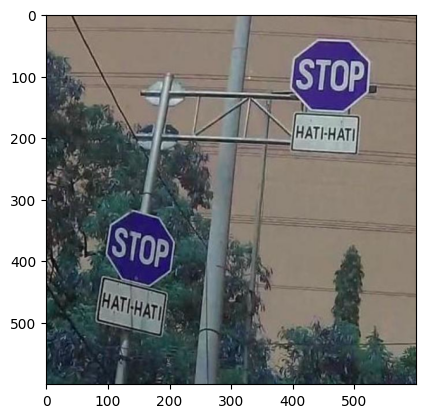

In [13]:
denormalize = NormalizeInverse(mean = [ 0.485, 0.456, 0.406 ],
                            std = [ 0.229, 0.224, 0.225 ])

batch = next(iter(test_loader))
plt.imshow(ToPILImage()(denormalize(batch['pixel_values'][1])))

In [14]:
from pprint import pprint
from torchmetrics.detection import MeanAveragePrecision

metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")

def test_model(trainer, test_loader):
    all_processed_out, all_labels = [], []
    for batch in test_loader:
        bs = batch['pixel_values'].shape[0]
        for element in batch['labels']:
            element["labels"] = element["class_labels"]

        out = trainer.predict(batch)

        trg_size = batch["target_sizes"]
        processed_out = image_processor.post_process_object_detection(out, target_sizes=trg_size)
        processed_out = perform_nms(batch, processed_out, scale=False)
        
        processed_out = [{k: v.cpu() for k, v in el.items()} for el in processed_out]
        all_processed_out.extend(processed_out)
        all_labels.extend([{k:v for k, v in item.items() if k in ["boxes", "iscrowd", "labels"]} for item in batch['labels']])

    metric.update(all_processed_out, all_labels)
    map_dict = metric.compute()
    return map_dict

In [ ]:
map_dict = test_model(trainer, test_loader)
map_dict

DETR, like many object detection models, uses a fixed number of object queries to predict objects in an image. When the training data contains only 1-2 objects per image, this can lead to multiple queries predicting the same object, resulting in overlapping bounding boxes.

NMS is applied to the post-processed DETR output because the model generates numerous overlapping boxes for the same image. This occurs because the training dataset typically contains only 1-2 objects per image, which is insufficient given the model's 100 object queries. To address this issue with such data, one can consider exploring alternative model architectures or adapting the object query strategy by training them from scratch.

In [15]:
from torchvision.ops import nms

def perform_nms(batch, processed_out, scale=True):
    nms_out = []
    for target_size, out_list in zip(batch["target_sizes"], processed_out):
        img_h, img_w = target_size.unbind(0)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=0).to(out_list['boxes'].device)
        boxes = out_list['boxes'] / scale_fct
        scores = out_list["scores"]
        keep = nms(boxes, scores, iou_threshold=0.7)
        boxes, scores, labels = boxes[keep, ...], scores[keep], out_list['labels'][keep]
        if scale:
            boxes = boxes * scale_fct
        nms_out.append({"scores": scores, "labels": labels, "boxes": boxes})
    return nms_out

In [16]:
def predict_and_plot_random_image_from_batch(batch, idx):
    out = trainer.predict(batch)
    bs = batch['pixel_values'].shape[0]
    trg_sizes = batch['target_sizes']
    proccesed_out = image_processor.post_process_object_detection(out, threshold=0.7, target_sizes=trg_sizes)
    proccesed_out = perform_nms(batch, proccesed_out)

    pil_image = dataset['test'][idx]['image']
    draw = ImageDraw.Draw(pil_image)
    scores, labels, boxes = proccesed_out[idx].values()

    for score, lbl, box in zip(scores, labels, boxes):
        x, y, x_max, y_max = tuple(box)
        draw.rectangle((x, y, x_max, y_max), outline="red", width=1)
        draw.text((x, y), id2label[int(lbl)], fill="white")

    plt.figure(figsize=(10, 10))
    plt.imshow(pil_image)
    return out, proccesed_out

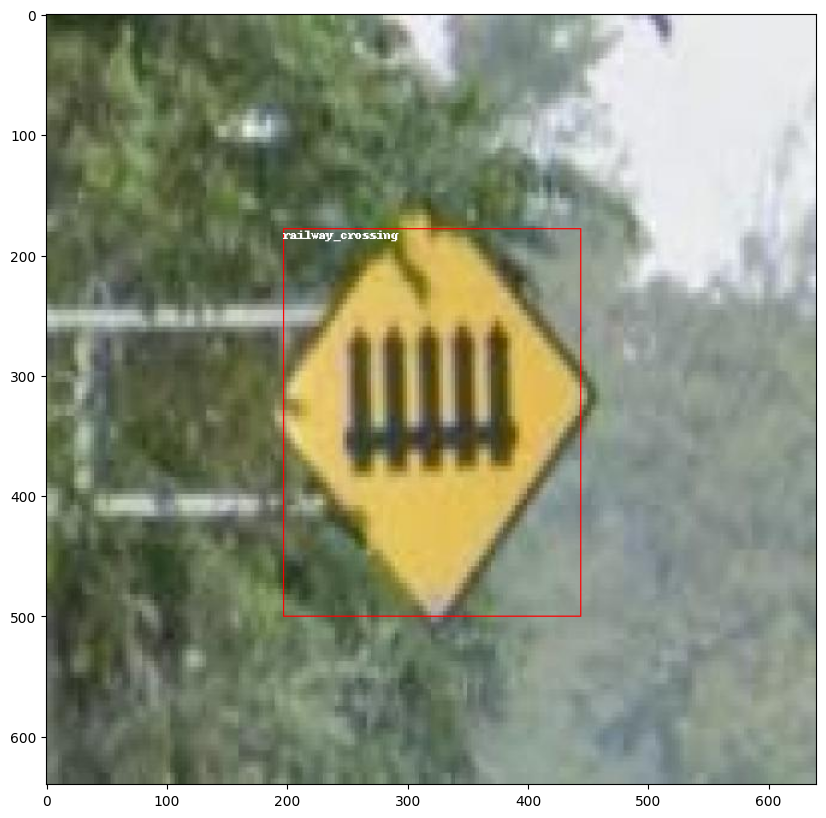

In [17]:
out, proccesed_out = predict_and_plot_random_image_from_batch(batch, 5)

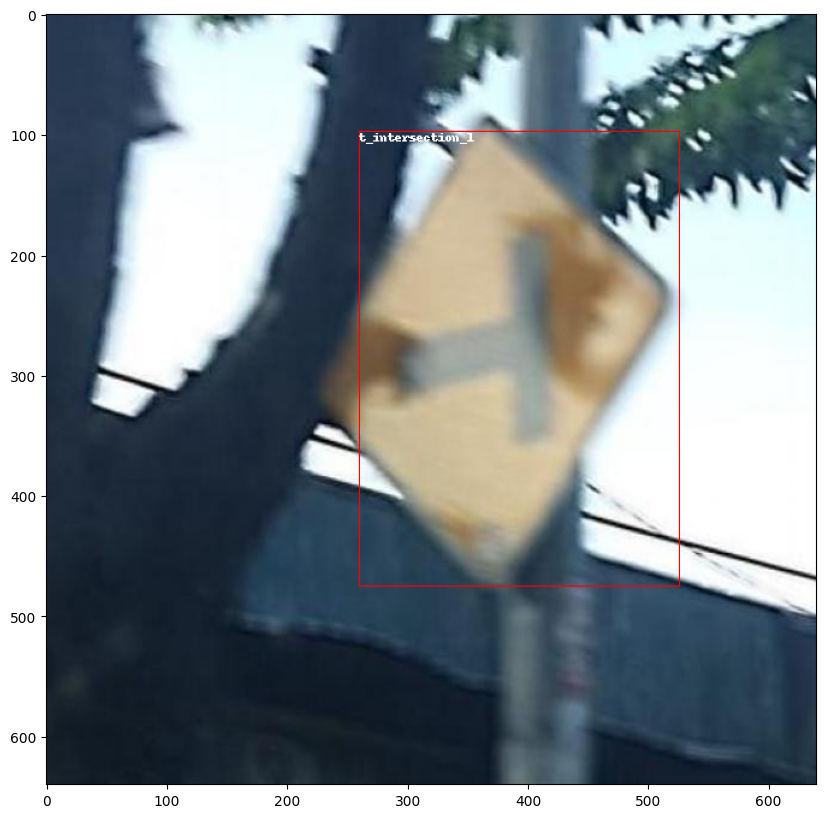

In [230]:
out, proccesed_out = predict_and_plot_random_image_from_batch(batch, 7)

# Infer the pre-trained model

In [97]:
# Instantiate the model
model_pretrained = DetrForObjectDetection.from_pretrained(
    model_id,
    cache_dir=cache_dir,
)

In [118]:
import requests
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [120]:
model_pretrained.eval()
im_tensor = image_processor(im, return_tensors="pt")
preds = model_pretrained(**im_tensor)

size = torch.tensor([im.size[::-1]])
out_processed = image_processor.post_process_object_detection(preds, threshold=0.7, target_sizes=size)
boxes = out_processed[0]['boxes'].detach().numpy()
labels = out_processed[0]['labels'].detach().numpy()

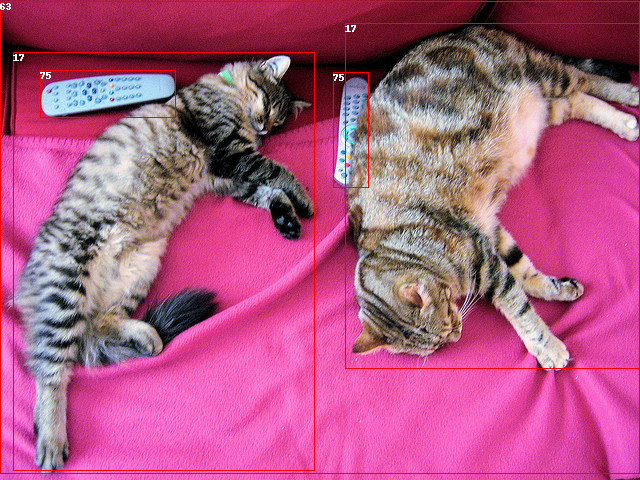

In [121]:
draw_new = ImageDraw.Draw(im)

for class_idx, box in zip(labels, boxes):
    x, y, xm, ym = tuple(box)
    draw_new.rectangle((x, y, xm, ym), outline="red", width=1)
    draw_new.text((x, y), str(int(class_idx)), fill="white")

im